In [1]:
! python3 -m pip install -U  scikit-learn pandas matplotlib tensorflow==2.0.0a0 > /dev/null
from utils import *

You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Introduction

This notebooks does not show any RNN. Instead, it motivates its usefulness by showing the limitations of Sequential auto-regression models. We use synthetic data generated by adding noise to the $sin()$ function:

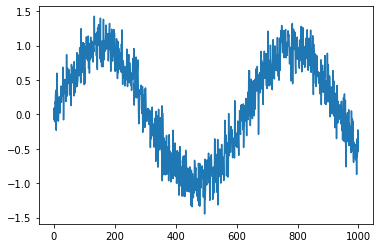

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
T = 1000
t = np.arange(0, T)
X = np.sin(0.01 * t) + 0.2 * np.random.normal(size=T)

plt.plot(t, X)

Since we are going to show a Sequential model with auto regression, we need to generate the new datapoints.:

In [3]:
window_size = 5
X_regr = np.zeros(shape=(T - window_size, window_size))
y_regr = X[window_size:]

for i in range(T - window_size):
    X_regr[i] = X[i: i+window_size]

# Let's create train/test split. 80/20
n_train = int(T * 0.8)
n_test = T - n_train

X_train = X_regr[:n_train]
X_test = X_regr[n_train:]
y_train = y_regr[:n_train]
y_test = y_regr[n_train:]

Let's define the network and train it:

Train on 800 samples, validate on 195 samples
Epoch 1/30
800/800 [==============================] - 0s 490us/sample - loss: 1.1197 - val_loss: 0.6013
Epoch 2/30
800/800 [==============================] - 0s 402us/sample - loss: 0.7588 - val_loss: 0.4212
Epoch 3/30
800/800 [==============================] - 0s 557us/sample - loss: 0.5688 - val_loss: 0.3346
Epoch 4/30
800/800 [==============================] - 0s 405us/sample - loss: 0.4579 - val_loss: 0.2873
Epoch 5/30
800/800 [==============================] - 0s 376us/sample - loss: 0.3852 - val_loss: 0.2536
Epoch 6/30
800/800 [==============================] - 0s 371us/sample - loss: 0.3319 - val_loss: 0.2275
Epoch 7/30
800/800 [==============================] - 0s 271us/sample - loss: 0.2905 - val_loss: 0.2057
Epoch 8/30
800/800 [==============================] - 0s 302us/sample - loss: 0.2570 - val_loss: 0.1871
Epoch 9/30
800/800 [==============================] - 0s 366us/sample - loss: 0.2294 - val_loss: 0.1712
Epoch 10/30
800/80

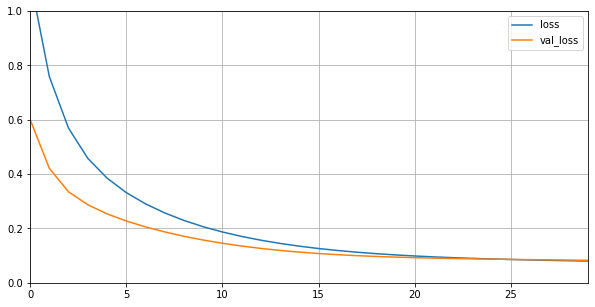

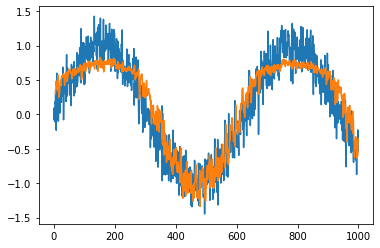

In [4]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(10, activation="relu", kernel_initializer="glorot_normal"))
model.add(keras.layers.Dense(1, kernel_initializer="glorot_normal"))
model.compile(optimizer="sgd", loss="mean_squared_error")
history = model.fit(X_train, y_train, batch_size=10, epochs=30, validation_data=(X_test, y_test))
draw_history(history)

estimates = model.predict(X_regr)
plt.plot(t, X)
plt.plot(t[window_size:], estimates)

As we can see from the graph above this model does a good job. However it's predicting power is limited a a few future steps. If we try to predict the future based on predictions (because we lack the ground truth), the results degrade pretty quickly. Let's take for example the point at $t = 600$ as the last ground truth and keep generating predictions based on the predictions obtained from there:

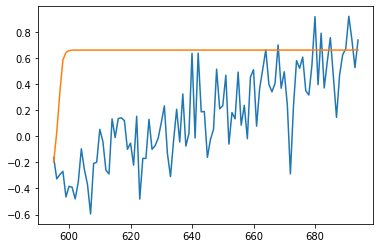

In [5]:
# Consider 600 the last point we have ground truth for, the idx of the 
# last ground truth auto-regression datapoint is 600 - window_size
start_time = 600 - window_size
datapoint = np.copy(X_regr[start_time].reshape(1, window_size))

time = t[start_time:]
# will only print 100 points to emphasize how quickly results degrade
plt.plot(time[0:100], X[start_time:start_time+100])

# Initialize the predictions
preds = np.zeros(shape=(len(time), 1))
for i in range(0, T - start_time):
    preds[i] = model.predict(datapoint)
    datapoint[:-1] = datapoint[1:]
    datapoint[-1] = preds[i]

# Again display only 100 points
plt.plot(time[:100], preds[:100])